# Training du RNN pour le captioning

# Intro

blablabla

# préparation de l'environnement

In [1]:
#imports
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

import tensorboard
import datetime

In [2]:
#Setting gpu for limit memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Chargement des données

In [3]:
# Chemin du fichier d'annotations
annotation_folder = "/annotations/"
annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
image_folder = '/train2014/'
PATH = os.path.abspath('.') + image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = '<start> ' + val['caption'] + ' <end>' #A COMPLETER
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption) #A COMPLETER
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:5000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []


print(len(train_image_paths))

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list) #A COMPLETER
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list)) #A COMPLETER
    #print(len(caption_list))

print(train_captions)

print(len(img_name_vector))


5000
['<start> A very clean and well decorated empty bathroom <end>', '<start> A blue and white bathroom with butterfly themed wall tiles. <end>', '<start> A bathroom with a border of butterflies and blue paint on the walls above it. <end>', '<start> An angled view of a beautifully decorated bathroom. <end>', '<start> A clock that blends in with the wall hangs in a bathroom.  <end>', '<start> A panoramic view of a kitchen and all of its appliances. <end>', '<start> A panoramic photo of a kitchen and dining room <end>', '<start> A wide angle view of the kitchen work area <end>', '<start> multiple photos of a brown and white kitchen.  <end>', '<start> A kitchen that has a checkered patterned floor and white cabinets. <end>', '<start> A graffiti-ed stop sign across the street from a red car  <end>', '<start> A vandalized stop sign and a red beetle on the road <end>', '<start> A red stop sign with a Bush bumper sticker under the word stop. <end>', '<start> A stop sign that has been vandali

## Préparation d'inceptionV3

In [4]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pre-traitement d'InceptionV3
print(image_dataset)
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

100%|██████████| 313/313 [00:41<00:00,  7.45it/s]


## Préparation du tokenizer

In [5]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] =  0
tokenizer.index_word[0] =  '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs =  tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector =   tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)


## Split test/train

In [6]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)



len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(20008, 20008, 5003, 5003)

# Entrainement

## Définition des paramètres

In [7]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 8000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Encodeur CNN
sortie d'inceptionV3 blablabla

In [8]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

## Décodeur RNN
blabla intro RNN
### Mécanisme d'attention
blabla badhanau

In [9]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

       # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
                    #(BATCH_SIZE,64,hidden_size) + (BATCH_SIZE,1,hidden_size)


        # attention_weights shape == (batch_size, 64, 1)
        # You get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)


        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        
        return context_vector, attention_weights

### Décodeur
blabla décodeur, gru etc

In [10]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
#A COMPLETER

        self.attention = BahdanauAttention(self.units)
#A COMPLETER

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
#A COMPLETER
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
#A COMPLETER

        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)
#A COMPLETER
        
        y = tf.reshape(output, (-1, x.shape[2]))

        # Couche dense
        y = x = self.fc1(y)
#A COMPLETER

        
        
        # Couche dense
        y = self.fc2(x)
#A COMPLETER
        
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Combinaison encodeur + décodeur

In [11]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
#A COMPLETER
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## Prepare training loop
### Optimizer and Loss
blabla

In [12]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam(0.001)
#A COMPLETER
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Callbacks
blabla callbacks

In [13]:

#CALLBACKS


def get_val_loss(dataset, encoder, decoder):
    total_loss = 0
    for (batch,(img_tensor, target)) in enumerate(dataset):
        loss = 0
        # Initialisation de l'état caché pour chaque batch
        hidden = decoder.reset_state(batch_size=target.shape[0])
        #print(tokenizer.word_index)

        # Initialiser l'entrée du décodeur
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

        t_loss = (loss / int(target.shape[1]))

    
        total_loss += t_loss

    return total_loss
    


class Callbacker():
    def __init__(self, tensorboard = True, early_stopping = True, es_patience = 0, save_model = True):

        time = datetime.datetime.now()
        self.training_name = f"{time.day}_{time.month}_{time.year}_{time.hour}h{time.minute}"
        #self.best_loss = np.Inf
        self.best_val_loss = np.Inf
        self.wait = 0
        self.stopped_epoch = 0


        self.btensorboard = tensorboard
        self.bearly_stopping = early_stopping
        self.es_patience = es_patience
        self.save_model = save_model

        self.stop_training = False

        if self.btensorboard == True:
            self.writer= tf.summary.create_file_writer(f"tensorboard/{self.training_name}")


    def epoch_callback(self, encoder_model, decoder_model, num_epoch:int, current_loss:float, current_val_loss:float):
        """
        at each epoch, this function will be launched, we will record our weights and save our model if we have the best result since the beeginning of the training.
        this function need as parameters:
        - encoder model: the encoder model (usually RNN).
        - decoder: the decoder model (usually RNN)
        - num epoch : the current epoch number
        - current loss : the current train loss
        - current_val_loss : the current loss for validation
        """
        print(f"The average loss for epoch {num_epoch} is loss :{current_loss}, val loss : {current_val_loss}")

        if self.btensorboard == True:
            with self.writer.as_default():
                tf.summary.scalar('loss', current_loss, step=num_epoch)
                tf.summary.scalar('val_loss', current_val_loss, step=num_epoch)

        if np.less(current_val_loss, self.best_val_loss):
            #self.best_loss = current_loss
            self.best_val_loss = current_val_loss
            self.wait = 0
            self.encoder_best_weights = encoder_model.get_weights()
            self.decoder_best_weights = decoder_model.get_weights()
            # Record the best weights if current results is better (less).
            if self.save_model == True:
                encoder_model.save(f'./models/{self.training_name}/encoder.tf')
                decoder_model.save(f'./models/{self.training_name}/decoder.tf')
        else:
            if self.bearly_stopping == True:
                self.wait += 1
                if self.wait >= self.es_patience:
                    self.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    encoder_model.set_weights(self.encoder_best_weights)
                    decoder_model.set_weights(self.decoder_best_weights)
        


### Training step function
blabla backpropagation

In [14]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    #print(tokenizer.word_index)

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        

        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

# Training
blabla train

In [18]:
EPOCHS = 50

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
val_dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
val_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



callbacker = Callbacker(es_patience= 3)

#create the directory
os.makedirs(f'./models/{callbacker.training_name}')
#save of the tokenizer
with open(f'./models/{callbacker.training_name}/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    #VALIDATION-------------------------------------------------------
    val_loss = get_val_loss(val_dataset,encoder,decoder)
    #------------------------------------------------------------------        
    
    #CALLBACK --------------------------------------------------------
    callbacker.epoch_callback(encoder, decoder, epoch, total_loss/num_steps, val_loss/num_steps)
    #-----------------------------------------------------------------
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Epoch 1 Batch 0 Loss 2.2360
Epoch 1 Batch 100 Loss 1.1180
Epoch 1 Batch 200 Loss 0.9439
Epoch 1 Batch 300 Loss 0.8488
The average loss for epoch 0 is loss :1.0514065027236938, val loss : 0.872481644153595
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 1 Loss 1.051407
Time taken for 1 epoch 908.4705266952515 sec

Epoch 2 Batch 0 Loss 0.8541
Epoch 2 Batch 100 Loss 0.8569
Epoch 2 Batch 200 Loss 0.7735
Epoch 2 Batch 300 Loss 0.8137
The average loss for epoch 1 is loss :0.8343081474304199, val loss : 0.7597780823707581
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 2 Loss 0.834308
Time taken for 1 epoch 815.9550149440765 sec

Epoch 3 Batch 0 Loss 0.7542
Epoch 3 Batch 100 Loss 0.7509
Epoch 3 Batch 200 Loss 0.6670
Epoch 3 Batch 300 Loss 0.7609
The average loss for epoch 2 is loss :0.7544806003570557, val loss : 0.6982104778289795
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 3 Loss 0.754481
Time taken for 1 epoch 815.1736521720886 sec

Epoch 4 Batch 0 Loss 0.7495
Epoch 4 Batch 100 Loss 0.7211
Epoch 4 Batch 200 Loss 0.6932
Epoch 4 Batch 300 Loss 0.7069
The average loss for epoch 3 is loss :0.7038360834121704, val loss : 0.6474610567092896
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 4 Loss 0.703836
Time taken for 1 epoch 835.7541286945343 sec

Epoch 5 Batch 0 Loss 0.6491
Epoch 5 Batch 100 Loss 0.6997
Epoch 5 Batch 200 Loss 0.6814
Epoch 5 Batch 300 Loss 0.6510
The average loss for epoch 4 is loss :0.663468062877655, val loss : 0.6071721911430359
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 5 Loss 0.663468
Time taken for 1 epoch 816.807178735733 sec

Epoch 6 Batch 0 Loss 0.5864
Epoch 6 Batch 100 Loss 0.6401
Epoch 6 Batch 200 Loss 0.6293
Epoch 6 Batch 300 Loss 0.5855
The average loss for epoch 5 is loss :0.6283591389656067, val loss : 0.5731390714645386
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 6 Loss 0.628359
Time taken for 1 epoch 861.3087754249573 sec

Epoch 7 Batch 0 Loss 0.5861
Epoch 7 Batch 100 Loss 0.6551
Epoch 7 Batch 200 Loss 0.6214
Epoch 7 Batch 300 Loss 0.6536
The average loss for epoch 6 is loss :0.5964229702949524, val loss : 0.5414561629295349
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 7 Loss 0.596423
Time taken for 1 epoch 818.3993682861328 sec

Epoch 8 Batch 0 Loss 0.4898
Epoch 8 Batch 100 Loss 0.5608
Epoch 8 Batch 200 Loss 0.5764
Epoch 8 Batch 300 Loss 0.6224
The average loss for epoch 7 is loss :0.5668145418167114, val loss : 0.5102911591529846
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 8 Loss 0.566815
Time taken for 1 epoch 839.3961701393127 sec

Epoch 9 Batch 0 Loss 0.5905
Epoch 9 Batch 100 Loss 0.5188
Epoch 9 Batch 200 Loss 0.5898
Epoch 9 Batch 300 Loss 0.5510
The average loss for epoch 8 is loss :0.5377421975135803, val loss : 0.4816857874393463
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 9 Loss 0.537742
Time taken for 1 epoch 850.4801185131073 sec

Epoch 10 Batch 0 Loss 0.4527
Epoch 10 Batch 100 Loss 0.5378
Epoch 10 Batch 200 Loss 0.5055
Epoch 10 Batch 300 Loss 0.5337
The average loss for epoch 9 is loss :0.5120875835418701, val loss : 0.45449045300483704
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 10 Loss 0.512088
Time taken for 1 epoch 832.3077292442322 sec

Epoch 11 Batch 0 Loss 0.4423
Epoch 11 Batch 100 Loss 0.5210
Epoch 11 Batch 200 Loss 0.5235
Epoch 11 Batch 300 Loss 0.5201
The average loss for epoch 10 is loss :0.48730894923210144, val loss : 0.43203163146972656
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 11 Loss 0.487309
Time taken for 1 epoch 816.6458308696747 sec

Epoch 12 Batch 0 Loss 0.4672
Epoch 12 Batch 100 Loss 0.4686
Epoch 12 Batch 200 Loss 0.4412
Epoch 12 Batch 300 Loss 0.4701
The average loss for epoch 11 is loss :0.4633333384990692, val loss : 0.4078826606273651
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 12 Loss 0.463333
Time taken for 1 epoch 822.1193799972534 sec

Epoch 13 Batch 0 Loss 0.4024
Epoch 13 Batch 100 Loss 0.4645
Epoch 13 Batch 200 Loss 0.4613
Epoch 13 Batch 300 Loss 0.4741
The average loss for epoch 12 is loss :0.4420011043548584, val loss : 0.3857794404029846
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 13 Loss 0.442001
Time taken for 1 epoch 862.0873417854309 sec

Epoch 14 Batch 0 Loss 0.3919
Epoch 14 Batch 100 Loss 0.4222
Epoch 14 Batch 200 Loss 0.4513
Epoch 14 Batch 300 Loss 0.4066
The average loss for epoch 13 is loss :0.4206140339374542, val loss : 0.36678633093833923
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 14 Loss 0.420614
Time taken for 1 epoch 811.5023829936981 sec

Epoch 15 Batch 0 Loss 0.4101
Epoch 15 Batch 100 Loss 0.3959
Epoch 15 Batch 200 Loss 0.4169
Epoch 15 Batch 300 Loss 0.3960
The average loss for epoch 14 is loss :0.4010760188102722, val loss : 0.34537890553474426
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 15 Loss 0.401076
Time taken for 1 epoch 859.6286482810974 sec

Epoch 16 Batch 0 Loss 0.3449
Epoch 16 Batch 100 Loss 0.3811
Epoch 16 Batch 200 Loss 0.3511
Epoch 16 Batch 300 Loss 0.3834
The average loss for epoch 15 is loss :0.3827572762966156, val loss : 0.3338306248188019
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 16 Loss 0.382757
Time taken for 1 epoch 819.3042232990265 sec

Epoch 17 Batch 0 Loss 0.3403
Epoch 17 Batch 100 Loss 0.3366
Epoch 17 Batch 200 Loss 0.3927
Epoch 17 Batch 300 Loss 0.4154
The average loss for epoch 16 is loss :0.36309799551963806, val loss : 0.31670740246772766
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 17 Loss 0.363098
Time taken for 1 epoch 824.8191137313843 sec

Epoch 18 Batch 0 Loss 0.3159
Epoch 18 Batch 100 Loss 0.3055
Epoch 18 Batch 200 Loss 0.3624
Epoch 18 Batch 300 Loss 0.3863
The average loss for epoch 17 is loss :0.34672418236732483, val loss : 0.30014073848724365
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 18 Loss 0.346724
Time taken for 1 epoch 849.9161076545715 sec

Epoch 19 Batch 0 Loss 0.3410
Epoch 19 Batch 100 Loss 0.3472
Epoch 19 Batch 200 Loss 0.3386
Epoch 19 Batch 300 Loss 0.3287
The average loss for epoch 18 is loss :0.32974839210510254, val loss : 0.28466612100601196
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 19 Loss 0.329748
Time taken for 1 epoch 849.633941411972 sec

Epoch 20 Batch 0 Loss 0.2807
Epoch 20 Batch 100 Loss 0.3020
Epoch 20 Batch 200 Loss 0.3180
Epoch 20 Batch 300 Loss 0.3315
The average loss for epoch 19 is loss :0.3145272731781006, val loss : 0.2670961022377014
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 20 Loss 0.314527
Time taken for 1 epoch 841.3533239364624 sec

Epoch 21 Batch 0 Loss 0.2905
Epoch 21 Batch 100 Loss 0.2716
Epoch 21 Batch 200 Loss 0.3448
Epoch 21 Batch 300 Loss 0.3022
The average loss for epoch 20 is loss :0.30382251739501953, val loss : 0.25580114126205444
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 21 Loss 0.303823
Time taken for 1 epoch 856.8411543369293 sec

Epoch 22 Batch 0 Loss 0.2989
Epoch 22 Batch 100 Loss 0.2819
Epoch 22 Batch 200 Loss 0.2960
Epoch 22 Batch 300 Loss 0.3048
The average loss for epoch 21 is loss :0.2876838743686676, val loss : 0.24072833359241486
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 22 Loss 0.287684
Time taken for 1 epoch 860.3212087154388 sec

Epoch 23 Batch 0 Loss 0.2432
Epoch 23 Batch 100 Loss 0.2556
Epoch 23 Batch 200 Loss 0.2795
Epoch 23 Batch 300 Loss 0.3281
The average loss for epoch 22 is loss :0.2761130928993225, val loss : 0.22661243379116058
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 23 Loss 0.276113
Time taken for 1 epoch 858.9242703914642 sec

Epoch 24 Batch 0 Loss 0.2395
Epoch 24 Batch 100 Loss 0.2633
Epoch 24 Batch 200 Loss 0.2310
Epoch 24 Batch 300 Loss 0.3019
The average loss for epoch 23 is loss :0.264309287071228, val loss : 0.22996823489665985
Epoch 24 Loss 0.264309
Time taken for 1 epoch 834.9466741085052 sec

Epoch 25 Batch 0 Loss 0.2488
Epoch 25 Batch 100 Loss 0.2564
Epoch 25 Batch 200 Loss 0.2452
Epoch 25 Batch 300 Loss 0.2991
The average loss for epoch 24 is loss :0.251363605260849, val loss : 0.2133152037858963
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 25 Loss 0.251364
Time taken for 1 epoch 862.7036309242249 sec

Epoch 26 Batch 0 Loss 0.2099
Epoch 26 Batch 100 Loss 0.2535
Epoch 26 Batch 200 Loss 0.2466
Epoch 26 Batch 300 Loss 0.2519
The average loss for epoch 25 is loss :0.24369685351848602, val loss : 0.1997276097536087
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 26 Loss 0.243697
Time taken for 1 epoch 798.7873706817627 sec

Epoch 27 Batch 0 Loss 0.2274
Epoch 27 Batch 100 Loss 0.2247
Epoch 27 Batch 200 Loss 0.2332
Epoch 27 Batch 300 Loss 0.2277
The average loss for epoch 26 is loss :0.2327500581741333, val loss : 0.19192494451999664
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 27 Loss 0.232750
Time taken for 1 epoch 864.0591232776642 sec

Epoch 28 Batch 0 Loss 0.1933
Epoch 28 Batch 100 Loss 0.2327
Epoch 28 Batch 200 Loss 0.2290
Epoch 28 Batch 300 Loss 0.2446
The average loss for epoch 27 is loss :0.2244991660118103, val loss : 0.18993470072746277
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 28 Loss 0.224499
Time taken for 1 epoch 842.0993514060974 sec

Epoch 29 Batch 0 Loss 0.2042
Epoch 29 Batch 100 Loss 0.2213
Epoch 29 Batch 200 Loss 0.2524
Epoch 29 Batch 300 Loss 0.2628
The average loss for epoch 28 is loss :0.21689818799495697, val loss : 0.17694732546806335
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 29 Loss 0.216898
Time taken for 1 epoch 861.2939276695251 sec

Epoch 30 Batch 0 Loss 0.2011
Epoch 30 Batch 100 Loss 0.1812
Epoch 30 Batch 200 Loss 0.2231
Epoch 30 Batch 300 Loss 0.2247
The average loss for epoch 29 is loss :0.21015521883964539, val loss : 0.1718488186597824
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 30 Loss 0.210155
Time taken for 1 epoch 833.796404838562 sec

Epoch 31 Batch 0 Loss 0.1861
Epoch 31 Batch 100 Loss 0.2005
Epoch 31 Batch 200 Loss 0.2108
Epoch 31 Batch 300 Loss 0.2299
The average loss for epoch 30 is loss :0.2048473358154297, val loss : 0.16337116062641144
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 31 Loss 0.204847
Time taken for 1 epoch 864.308126449585 sec

Epoch 32 Batch 0 Loss 0.1777
Epoch 32 Batch 100 Loss 0.1904
Epoch 32 Batch 200 Loss 0.1839
Epoch 32 Batch 300 Loss 0.1997
The average loss for epoch 31 is loss :0.19589762389659882, val loss : 0.16185489296913147
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 32 Loss 0.195898
Time taken for 1 epoch 846.9474611282349 sec

Epoch 33 Batch 0 Loss 0.1755
Epoch 33 Batch 100 Loss 0.1843
Epoch 33 Batch 200 Loss 0.1946
Epoch 33 Batch 300 Loss 0.1993
The average loss for epoch 32 is loss :0.19134056568145752, val loss : 0.15820170938968658
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 33 Loss 0.191341
Time taken for 1 epoch 829.6806590557098 sec

Epoch 34 Batch 0 Loss 0.1789
Epoch 34 Batch 100 Loss 0.1912
Epoch 34 Batch 200 Loss 0.1850
Epoch 34 Batch 300 Loss 0.2012
The average loss for epoch 33 is loss :0.18528181314468384, val loss : 0.18864929676055908
Epoch 34 Loss 0.185282
Time taken for 1 epoch 855.9417660236359 sec

Epoch 35 Batch 0 Loss 0.1970
Epoch 35 Batch 100 Loss 0.1887
Epoch 35 Batch 200 Loss 0.1691
Epoch 35 Batch 300 Loss 0.2051
The average loss for epoch 34 is loss :0.1867726594209671, val loss : 0.14360089600086212
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 35 Loss 0.186773
Time taken for 1 epoch 870.5755426883698 sec

Epoch 36 Batch 0 Loss 0.1552
Epoch 36 Batch 100 Loss 0.1653
Epoch 36 Batch 200 Loss 0.1827
Epoch 36 Batch 300 Loss 0.2026
The average loss for epoch 35 is loss :0.17560328543186188, val loss : 0.15033848583698273
Epoch 36 Loss 0.175603
Time taken for 1 epoch 837.7160036563873 sec

Epoch 37 Batch 0 Loss 0.1442
Epoch 37 Batch 100 Loss 0.1713
Epoch 37 Batch 200 Loss 0.1599
Epoch 37 Batch 300 Loss 0.2001
The average loss for epoch 36 is loss :0.1739959418773651, val loss : 0.13870809972286224
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 37 Loss 0.173996
Time taken for 1 epoch 815.1622819900513 sec

Epoch 38 Batch 0 Loss 0.1663
Epoch 38 Batch 100 Loss 0.1637
Epoch 38 Batch 200 Loss 0.1772
Epoch 38 Batch 300 Loss 0.2137
The average loss for epoch 37 is loss :0.1682751178741455, val loss : 0.14025595784187317
Epoch 38 Loss 0.168275
Time taken for 1 epoch 856.5457012653351 sec

Epoch 39 Batch 0 Loss 0.1535
Epoch 39 Batch 100 Loss 0.1564
Epoch 39 Batch 200 Loss 0.1499
Epoch 39 Batch 300 Loss 0.1758
The average loss for epoch 38 is loss :0.1634368598461151, val loss : 0.13509583473205566
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 39 Loss 0.163437
Time taken for 1 epoch 844.374073266983 sec

Epoch 40 Batch 0 Loss 0.1417
Epoch 40 Batch 100 Loss 0.1780
Epoch 40 Batch 200 Loss 0.1838
Epoch 40 Batch 300 Loss 0.1843
The average loss for epoch 39 is loss :0.16514398157596588, val loss : 0.1398092657327652
Epoch 40 Loss 0.165144
Time taken for 1 epoch 815.5929503440857 sec

Epoch 41 Batch 0 Loss 0.1461
Epoch 41 Batch 100 Loss 0.1373
Epoch 41 Batch 200 Loss 0.1573
Epoch 41 Batch 300 Loss 0.1794
The average loss for epoch 40 is loss :0.1639309525489807, val loss : 0.13259229063987732
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 41 Loss 0.163931
Time taken for 1 epoch 834.1268255710602 sec

Epoch 42 Batch 0 Loss 0.1604
Epoch 42 Batch 100 Loss 0.1718
Epoch 42 Batch 200 Loss 0.1624
Epoch 42 Batch 300 Loss 0.1683
The average loss for epoch 41 is loss :0.15806269645690918, val loss : 0.1207549124956131
INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_0h8/decoder.tf\assets


Epoch 42 Loss 0.158063
Time taken for 1 epoch 853.2263627052307 sec

Epoch 43 Batch 0 Loss 0.1354
Epoch 43 Batch 100 Loss 0.1559
Epoch 43 Batch 200 Loss 0.1521
Epoch 43 Batch 300 Loss 0.1684
The average loss for epoch 42 is loss :0.1503487378358841, val loss : 0.12238595634698868
Epoch 43 Loss 0.150349
Time taken for 1 epoch 883.4741578102112 sec

Epoch 44 Batch 0 Loss 0.1441
Epoch 44 Batch 100 Loss 0.1391
Epoch 44 Batch 200 Loss 0.1715
Epoch 44 Batch 300 Loss 0.1697
The average loss for epoch 43 is loss :0.1516278088092804, val loss : 0.12198767066001892
Epoch 44 Loss 0.151628
Time taken for 1 epoch 856.7491459846497 sec

Epoch 45 Batch 0 Loss 0.1468
Epoch 45 Batch 100 Loss 0.1262


KeyboardInterrupt: 

# display the trained model's results
Fonctions:

In [19]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Reshape predictions to be a 2D matrix of shape [batch_size, vocab_size]
        predictions = tf.reshape(predictions, [1, -1])

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Affichage

d:\CESI\A5\datascience\Projet\DataScience\Livrable_3/train2014/COCO_train2014_000000495122.jpg
Real Caption: <start> a very large kitchen with all white cabinets and counter tops <end>
Prediction Caption: a refrigerator and some cabinets in a refrigerator standing next to a refrigerator and a refrigerator <end>


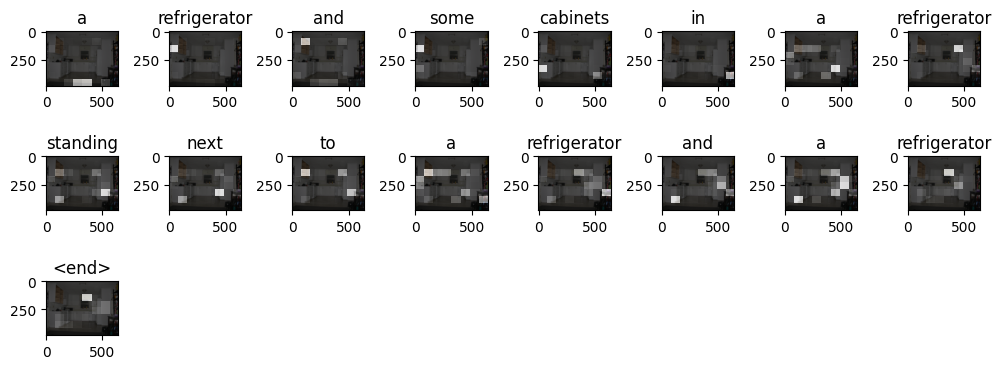

In [23]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# Sélection du meilleur modèle
Blabla grosse section à faire